In [1]:
from sklearn.datasets import load_boston

Use `load_boston` to load the Boston Housing Dataset.
You must create a Linear Regression model fitted to this data to predict house prices.

- Check the data for nulls
- Explore the data, distributions, correlations.
- Take that into mind when choosing the features for your model.
- Watch out for colinearity.
- Split your data into train and test. [Check out how!](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)
- Measure the goodness of your fit! $R^2$, $RMSE$, etc.
- Try to make it better.
- Do your own research. Checkout both sklearn and statsmodels, get a feel of both.
- Have fun.


### Further resources

- [The internet is your friend](https://towardsdatascience.com/simple-and-multiple-linear-regression-with-python-c9ab422ec29c)
- [Scikit-Learn](https://scikit-learn.org)
- [Statsmodels](https://statsmodels.org)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing

import statsmodels.api as smf

from sklearn.utils import shuffle

from statsmodels.tools.eval_measures import rmse

In order to load the dataset, we execute the `load_boston` function, that loads a dictionary.

In [3]:
boston = load_boston()
boston.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename'])

Below it is printed the description of the dataset, that is stored in `DESCR`

In [4]:
print(boston.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

I will create a DataFrame for the features (df) and Series for the target (y) for the initial investigation of the data.

In [6]:
df = pd.DataFrame(boston.data, columns=boston.feature_names)
y = pd.Series(boston.target)
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


After that it is necessary to examine for nan in the dataset, but no one found.

In [7]:
df.isna().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
dtype: int64

#### CATEGORICAL DATA CHECKING

There are two columns that are clearly categorical, that are the following:
- CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
- RAD      index of accessibility to radial highways

Some categories do not have much datapoints (<40)

In [8]:
df["CHAS"].value_counts()

0.0    471
1.0     35
Name: CHAS, dtype: int64

In [9]:
df["RAD"].value_counts()

24.0    132
5.0     115
4.0     110
3.0      38
6.0      26
8.0      24
2.0      24
1.0      20
7.0      17
Name: RAD, dtype: int64

The "CHAS" one no not need additional processing, but for "RAD" we will create dummies categorical columns.

In [10]:
dummies = pd.get_dummies(df['RAD'])
cols = []
for col in dummies.columns:
    cols.append("RAD "+str(int(col)))

dummies.columns=cols
dummies.head()

,RAD 1,RAD 2,RAD 3,RAD 4,RAD 5,RAD 6,RAD 7,RAD 8,RAD 24
0,1,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0


No I will join the dummies and the target to the DataFrame to examine all together.

In [11]:
df=df.join(dummies)
df["TARGET"] = y

#### SELECTION OF THE CONSPICUOS FEATURES

Now it is necessary to check the correlations between all variables and the target to select which of them have weak correlation or no correlation at all. We want to ignore these features as they are not going to help the fitting process.

In [12]:
correl =df.corr()["TARGET"]
correl

CRIM      -0.388305
ZN         0.360445
INDUS     -0.483725
CHAS       0.175260
NOX       -0.427321
RM         0.695360
AGE       -0.376955
DIS        0.249929
RAD       -0.381626
TAX       -0.468536
PTRATIO   -0.507787
B          0.333461
LSTAT     -0.737663
RAD 1      0.040453
RAD 2      0.104444
RAD 3      0.167352
RAD 4     -0.065711
RAD 5      0.187356
RAD 6     -0.039411
RAD 7      0.092802
RAD 8      0.190053
RAD 24    -0.396297
TARGET     1.000000
Name: TARGET, dtype: float64

In order to select low correlations, we will use a $ |\rho| \lt 0.4 $. In this figure I will show different correlations to visualize what kind of relationships we are using and which distributions we are going to ignore.

![plot](http://4.bp.blogspot.com/-x4mHpvd3Exk/Uw9hhfZqZwI/AAAAAAAAEes/pJuiDgyaaGA/s1600/Screen+Shot+2014-02-27+at+11.01.41+AM.png)

In [13]:
correl[abs(correl)<0.40]

CRIM     -0.388305
ZN        0.360445
CHAS      0.175260
AGE      -0.376955
DIS       0.249929
RAD      -0.381626
B         0.333461
RAD 1     0.040453
RAD 2     0.104444
RAD 3     0.167352
RAD 4    -0.065711
RAD 5     0.187356
RAD 6    -0.039411
RAD 7     0.092802
RAD 8     0.190053
RAD 24   -0.396297
Name: TARGET, dtype: float64

In [14]:
correl[abs(correl)>0.40]

INDUS     -0.483725
NOX       -0.427321
RM         0.695360
TAX       -0.468536
PTRATIO   -0.507787
LSTAT     -0.737663
TARGET     1.000000
Name: TARGET, dtype: float64

No one of the precious dummies have an strong relationship, nor the numerical index, so these are not neccesary.

The only features that are important are:
- INDUS	
- NOX	
- RM	
- TAX	
- PTRATIO	
- LSTAT	
- TARGET

We redefine the dataset with these findings.

In [15]:
df=df[correl[abs(correl)>0.40].index]
df.head()

,INDUS,NOX,RM,TAX,PTRATIO,LSTAT,TARGET
0,2.31,0.538,6.575,296.0,15.3,4.98,24.0
1,7.07,0.469,6.421,242.0,17.8,9.14,21.6
2,7.07,0.469,7.185,242.0,17.8,4.03,34.7
3,2.18,0.458,6.998,222.0,18.7,2.94,33.4
4,2.18,0.458,7.147,222.0,18.7,5.33,36.2


#### CHECKING COLINEARITY

Now I will check the relation between features to check the colinearity between variables.

Looking at the correlation matrix, there seems to be no problem with colinearity, as there are not columns that are correlated enough.

In [16]:
df.corr()

,INDUS,NOX,RM,TAX,PTRATIO,LSTAT,TARGET
INDUS,1.000000,0.763651,-0.391676,0.720760,0.383248,0.603800,-0.483725
NOX,0.763651,1.000000,-0.302188,0.668023,0.188933,0.590879,-0.427321
RM,-0.391676,-0.302188,1.000000,-0.292048,-0.355501,-0.613808,0.695360
TAX,0.720760,0.668023,-0.292048,1.000000,0.460853,0.543993,-0.468536
PTRATIO,0.383248,0.188933,-0.355501,0.460853,1.000000,0.374044,-0.507787
LSTAT,0.603800,0.590879,-0.613808,0.543993,0.374044,1.000000,-0.737663
TARGET,-0.483725,-0.427321,0.695360,-0.468536,-0.507787,-0.737663,1.000000


In [17]:
df.corr()[df.corr() > 0.9]

,INDUS,NOX,RM,TAX,PTRATIO,LSTAT,TARGET
INDUS,1.0,NaN,NaN,NaN,NaN,NaN,NaN
NOX,NaN,1.0,NaN,NaN,NaN,NaN,NaN
RM,NaN,NaN,1.0,NaN,NaN,NaN,NaN
TAX,NaN,NaN,NaN,1.0,NaN,NaN,NaN
PTRATIO,NaN,NaN,NaN,NaN,1.0,NaN,NaN
LSTAT,NaN,NaN,NaN,NaN,NaN,1.0,NaN
TARGET,NaN,NaN,NaN,NaN,NaN,NaN,1.0


Now using seaborn I will take a look at all the selected variables to visualize them

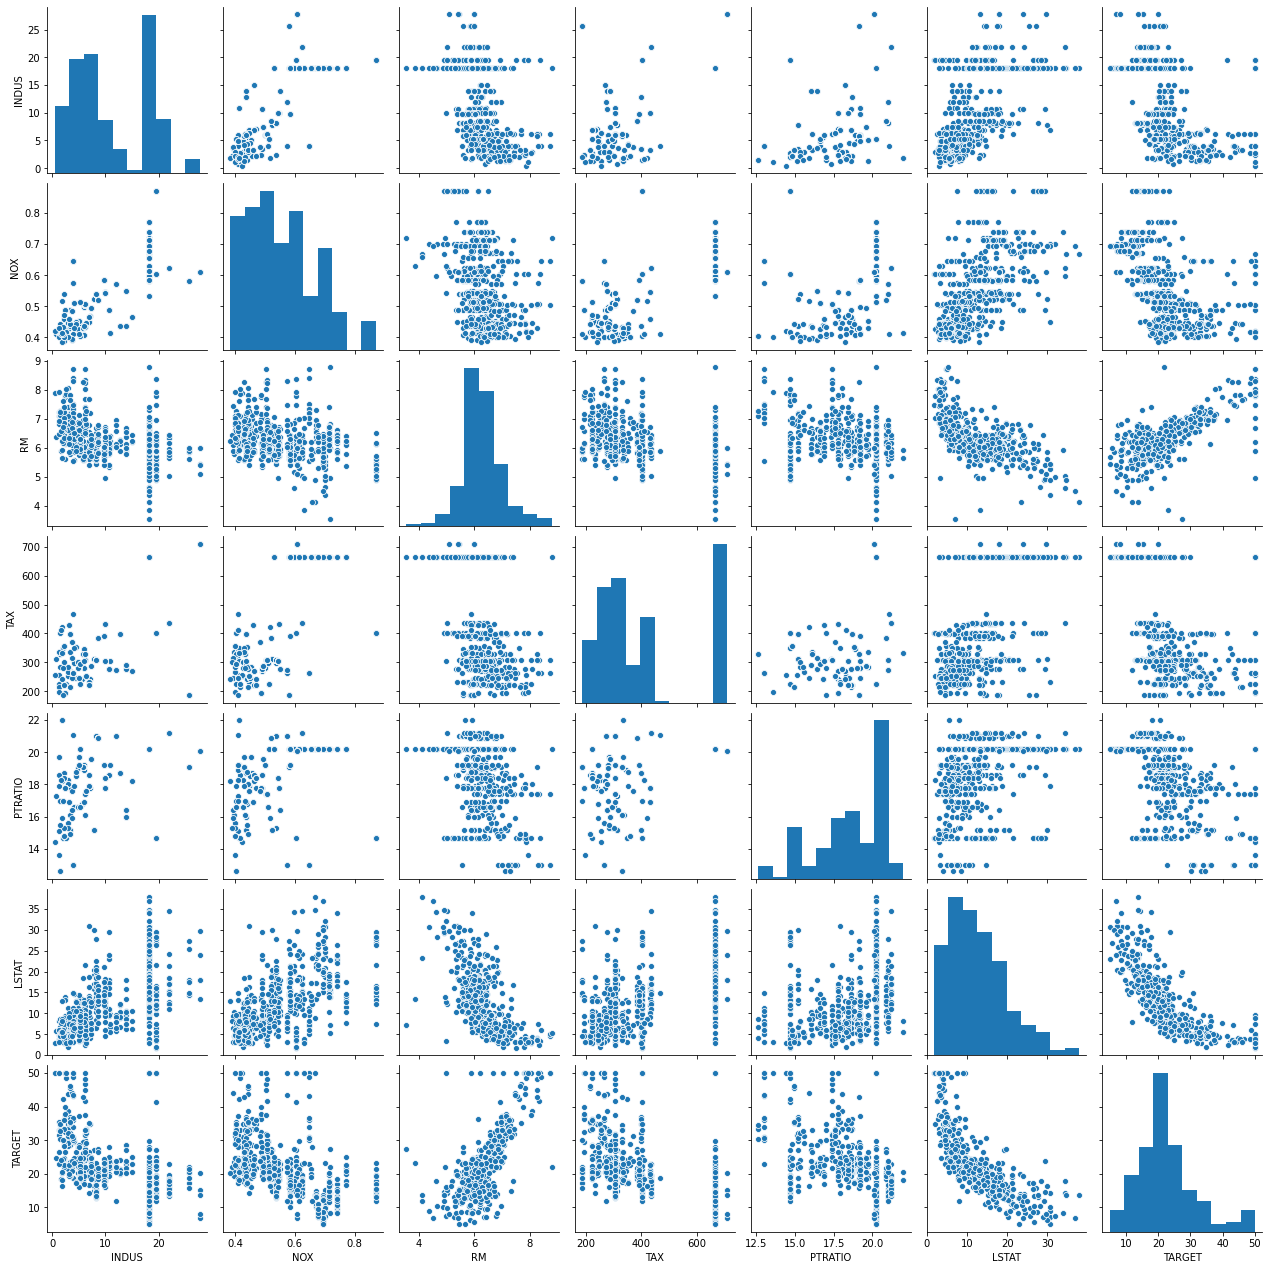

In [18]:
sns.pairplot(df)

The histograms of "TAX" and "INDUS" might incicate that they could be converted as categorical, but looking the shape of the relations we will keep them as non-categorical.

Now let0s visualize the target column.

Text(0.5, 1.0, "Median value of owner-occupied homes in $1000's")

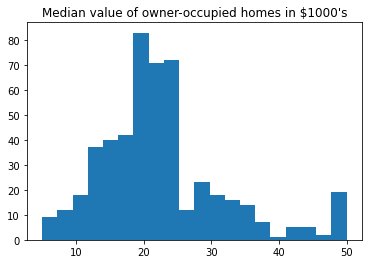

In [20]:
plt.hist(y,bins=20);
plt.title("Median value of owner-occupied homes in $1000's")

#### FITTING PROCEDURE

Normalizing values using max-min:

$$ \frac{X_i - X_{min}}{X_{max}-X_{min}}$$

In [21]:
df["TARGET"] = y

# Normalize_x
x = df.values #returns a numpy array
cols = df.columns
norm_fun = preprocessing.MinMaxScaler()
norm = norm_fun.fit_transform(x)   # dfn2=pd.DataFrame(renorm.inverse_transform(dfn))
dfn = pd.DataFrame(norm)
dfn.columns=cols

dfn.head()

,INDUS,NOX,RM,TAX,PTRATIO,LSTAT,TARGET
0,0.067815,0.314815,0.577505,0.208015,0.287234,0.089680,0.422222
1,0.242302,0.172840,0.547998,0.104962,0.553191,0.204470,0.368889
2,0.242302,0.172840,0.694386,0.104962,0.553191,0.063466,0.660000
3,0.063050,0.150206,0.658555,0.066794,0.648936,0.033389,0.631111
4,0.063050,0.150206,0.687105,0.066794,0.648936,0.099338,0.693333


In [22]:
dfn["TARGET"].value_counts()

1.000000    16
0.444444     8
0.402222     7
0.377778     7
0.371111     7
            ..
0.542222     1
0.157778     1
0.133333     1
0.266667     1
0.611111     1
Name: TARGET, Length: 229, dtype: int64

In [23]:
# Shuffle dataset
dfn = shuffle(dfn)
# Divide between x and y
xn=dfn.loc[:, dfn.columns != 'TARGET']
yn=dfn["TARGET"]
# Train/Test dividing using 80% train and 20% test
div = int(len(dfn)*0.8)
xn_train = xn[:div]
yn_train = yn[:div]
xn_test = xn[div:]
yn_test = yn[div:]

Fit using train dataset

In [24]:
xn_train = smf.add_constant(xn_train)
multi_lm = smf.OLS(yn_train,xn_train).fit()

In [25]:
multi_lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 TARGET   R-squared:                       0.659
Model:                            OLS   Adj. R-squared:                  0.654
Method:                 Least Squares   F-statistic:                     127.8
Date:                Wed, 25 Nov 2020   Prob (F-statistic):           1.74e-89
Time:                        18:59:31   Log-Likelihood:                 282.01
No. Observations:                 404   AIC:                            -550.0
Df Residuals:                     397   BIC:                            -522.0
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3648      0.046      7.939      0.000       0.274       0.455
INDUS          0.0655      0.045      1.447      0.149      -0.023       0.154
NOX           -0.0405      0.044     -0.919      0.359      -0.127       0.046
RM             0.5350      0.060      8.952      0.000       0.417       0.652
TAX           -0.0135      0.030     -0.443      0.658      -0.073       0.046
PTRATIO       -0.1916      0.032     -5.960      0.000      -0.255      -0.128
LSTAT         -0.4608      0.048     -9.683      0.000      -0.554      -0.367
==============================================================================
Omnibus:                      175.786   Durbin-Watson:                   2.061
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              855.057
Skew:                           1.852   Prob(JB):                    2.12e-186
Kurtosis:                       9.088   Cond. No.                         19.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Check errors with test database

In [26]:
xn_test=smf.add_constant(xn_test)

yn_predict = multi_lm.predict(xn_test)
rms=rmse(yn_predict,yn_test)

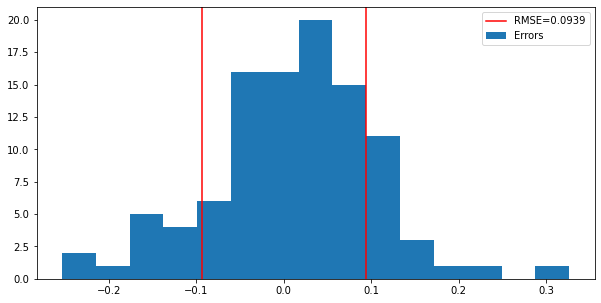

In [27]:
plt.figure(figsize=(10,5))
plt.axvline(x=rms,color="r")
plt.axvline(x=-rms,color="r",label=f"RMSE={round(rms,4)}")
plt.hist(yn_predict-yn_test,bins=15,label="Errors")
plt.legend();

(array([4., 3., 7., 7., 1., 0., 1., 2., 3., 2.]),
 array([0.01333333, 0.112     , 0.21066667, 0.30933333, 0.408     ,
        0.50666667, 0.60533333, 0.704     , 0.80266667, 0.90133333,
        1.        ]),
 <a list of 10 Patch objects>)

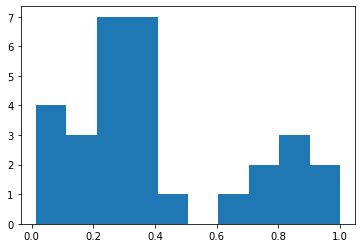

In [30]:
outliers_i = yn_test[abs(yn_predict-yn_test) > rms]
plt.hist(outliers_i);